In [5]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import os

In [4]:
print(tf.__version__)
print(keras.__version__)

2.0.0
2.2.4-tf


In [27]:
image_datas = glob('./*/*.jpg')
print(image_datas)
class_name = ['americancasual', 'casual', 'chic', 'dandy', 'formal', 'girlish', 'homewear', 'retro', 'romantic', 'sports', 'street']
dic = {'americancasual':0, 'casual':1, 'chic':2, 'dandy':3, 'formal':4, 'girlish':5,'homewear':6, 'retro':7, 'romantic':8, 'sports':9, 'street':10}

['./formal/호주_Darrick Lim(연령미상) 15-09-08 조회수50.jpg', './formal/신사_압구정_미사키(연령미상) 15-08-10 조회수95.jpg', './formal/부산_경남_이정욱(30) 20-05-12 조회수57.jpg', './formal/신사_압구정_김유나(연령미상) 22-02-17 조회수14.jpg', './formal/대전_충청_이남재(50) 14-02-11 조회수36.jpg', './formal/동대문_Anzhelika(연령미상) 15-10-24 조회수66.jpg', './formal/이탈리아_alice(28) 19-10-14 조회수39.jpg', './formal/홍대_신촌_김경수(26) 16-11-09 조회수36.jpg', './formal/부산_경남_김진혁(연령미상) 15-10-05 조회수16.jpg', './formal/부산_경남_이광원(69) 11-01-12 조회수69.jpg', './formal/동대문_최용환(60) 19-03-21 조회수45.jpg', './formal/부산_경남_김동현(연령미상) 16-10-07 조회수11.jpg', './formal/신사_압구정_양동규(27) 21-03-29 조회수61.jpg', './formal/뉴욕_미국동부_Kirk Rummer(연령미상) 15-09-09 조회수14.jpg', './formal/동대문_윤태양(연령미상) 18-04-04 조회수02.jpg', './formal/특집_함종승(25) 10-11-0

In [34]:
X=[]
Y=[]
for imagename in image_datas:
  image = Image.open(imagename).convert('RGB')
  image = image.resize((128,128))
  image = np.asarray(image)
  X.append(image)
  label = imagename.split('/')[1]
  label = dic[label]
  Y.append(label)

In [35]:
X = np.array(X)
Y = np.array(Y)

In [37]:
train_images, test_images, train_labels, test_labels = train_test_split(X,Y,test_size=0.2, shuffle=True, random_state=44)

train_labels = train_labels[..., tf.newaxis]
test_labels = test_labels[..., tf.newaxis]

print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(9856, 128, 128, 3) (9856, 1) (2465, 128, 128, 3) (2465, 1)


In [41]:
## training set의 각 class 별 image 수 확인
unique, counts = np.unique(np.reshape(train_labels, (9856,)),axis=-1, return_counts=True) #이어서 쓰기
dict(zip(unique, counts))

{0: 1497, 2: 319, 3: 79, 4: 1409, 6: 3, 7: 58, 9: 11, 10: 6480}

In [42]:
## test set의 각 class 별 image 수 확인
unique, counts = np.unique(np.reshape(test_labels, (2465,)),axis=-1, return_counts=True) #이어서 쓰기
dict(zip(unique, counts))

{0: 360, 2: 74, 3: 13, 4: 367, 7: 15, 10: 1636}

In [43]:
N_TRAIN = train_images.shape[0]
N_TEST = test_images.shape[0]

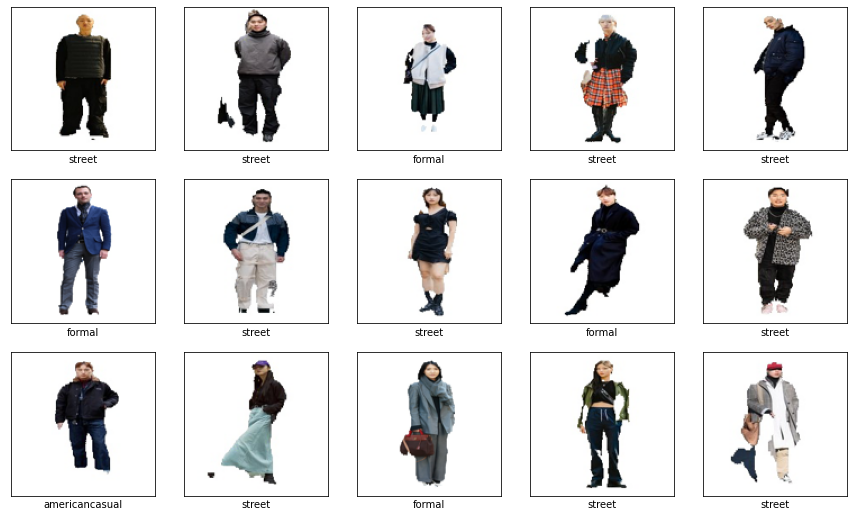

In [46]:
##DATA 확인
plt.figure(figsize=(15,9))
for i in range(15):
  img_idx = np.random.randint(0,9856)
  plt.subplot(3,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[img_idx])
  plt.xlabel(class_name[train_labels[img_idx][0]])

In [47]:
#pixel 값을 0~1 사이 범위로 조정
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.

#label을 one-hot-encoding
train_labels = keras.utils.to_categorical(train_labels)
test_labels = keras.utils.to_categorical(test_labels)

In [48]:
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(9856, 128, 128, 3) (9856, 11)
(2465, 128, 128, 3) (2465, 11)


In [49]:
#Hyper-parameters
learning_rate = 0.01
N_EPOCHS = 10
N_BATCH = 50
N_CLASS = 5

In [51]:
##dataset 구성

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(buffer_size=9856).batch(N_BATCH).repeat()

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(N_BATCH)

In [66]:
# Sequential API 사용 model 구성

def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3,
                                 activation='relu',padding='SAME',
                                 input_shape=(128,128,3)))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3,
                                 activation='relu',padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3,
                                 activation='relu',padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256,activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(11,activation='softmax'))
    return model

In [67]:
## Create model. 컴파일& 서머리

model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
             loss='categorical_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 32768)            

In [68]:
## Parameters for training

steps_per_epoch = int(N_TRAIN/N_BATCH)
validation_steps = int(N_TEST/N_BATCH)
print(steps_per_epoch, validation_steps)

197 49


In [69]:
##Training

history = model.fit(train_dataset, epochs=N_EPOCHS, steps_per_epoch=steps_per_epoch,
                   validation_data=test_dataset, validation_steps=validation_steps)

Train for 197 steps, validate for 49 steps
Epoch 1/10
197/197 [==============================] - 542s 3s/step - loss: 3.0505 - accuracy: 0.6455 - val_loss: 1.0023 - val_accuracy: 0.6649
Epoch 2/10
197/197 [==============================] - 560s 3s/step - loss: 1.0481 - accuracy: 0.6570 - val_loss: 0.9965 - val_accuracy: 0.6649
Epoch 3/10
197/197 [==============================] - 559s 3s/step - loss: 1.0348 - accuracy: 0.6590 - val_loss: 0.9960 - val_accuracy: 0.6649
Epoch 4/10
197/197 [==============================] - 562s 3s/step - loss: 1.0078 - accuracy: 0.6565 - val_loss: 0.9540 - val_accuracy: 0.6653
Epoch 5/10
197/197 [==============================] - 568s 3s/step - loss: 0.9767 - accuracy: 0.6589 - val_loss: 0.9226 - val_accuracy: 0.6657
Epoch 6/10
197/197 [==============================] - 563s 3s/step - loss: 0.9456 - accuracy: 0.6633 - val_loss: 0.9030 - val_accuracy: 0.6727
Epoch 7/10
197/197 [==============================] - 576s 3s/step - loss: 0.9486 - accuracy: 0.663

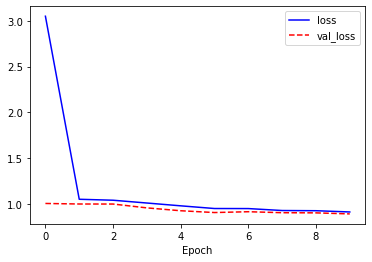

In [70]:
##Plot losses

plt.plot(history.history['loss'],'b-',label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

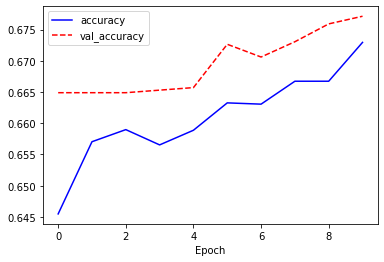

In [71]:
##Plot accuracy

plt.plot(history.history['accuracy'],'b-',label='accuracy')
plt.plot(history.history['val_accuracy'], 'r--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [72]:
def plot_image(i,predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i],img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_name[predicted_label],
                                        100*np.max(predictions_array),
                                        class_name[true_label]),
                                        color=color)
    
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    
    plt.xticks(range(N_CLASS), class_name, rotation=90)
    plt.yticks([])
    thisplot = plt.bar(range(N_CLASS), predictions_array, color= "#777777")
    plt.ylim([0,1])
    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of ticklabels (11).

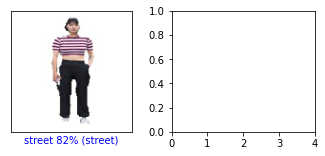

In [73]:
rnd_idx = np.random.randint(1, N_TEST//N_BATCH)
img_cnt = 0

for images, labels in test_dataset:
    img_cnt += 1
    if img_cnt != rnd_idx:
        continue
    predictions = model(images, training=False)
    num_rows = 5
    num_cols = 3
    num_images = num_rows * num_cols
    labels = tf.argmax(labels, axis=-1)
    plt.figure(figsize=(3*2*num_cols, 4*num_rows))
    plt.subplots_adjust(hspace=1.0)
    
    for i in range(num_images):
        plt.subplot(num_rows, 2* num_cols, 2*i+1)
        plot_image(i, predictions.numpy(), labels.numpy(), images.numpy())
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions.numpy(), labels.numpy())
    break

In [ ]:
# Functional API 사용 model 구성

def create_model2():
    inputs = keras.Input(shape=(128,128, 3))
    conv1 = keras.layers.Conv2D(filters=32, kernel_size=[3,3],
                                 padding='SAME',activation='relu')(inputs)
                                 
    pool1 = keras.layers.MaxPool2D(padding='SAME')(conv1)
    
    
    conv2 = keras.layers.Conv2D(filters=64, kernel_size=[3,3],
                                 padding='SAME',activation='relu')(pool1)
    pool2 = keras.layers.MaxPool2D(padding='SAME')(conv2)
    
    
    conv3 = keras.layers.Conv2D(filters=64, kernel_size=[3,3],
                                 padding='SAME',activation='relu')(pool2)
    pool3 = keras.layers.MaxPool2D(padding='SAME')(conv3)
    
    pool3_flat = keras.layers.Flatten()(pool3)
    
    dense4 = deras.layers.Dense(units=256, activation='relu')(pool3_flat)
    drop4 = keras.layers.Dropout(rate=0.4)(dense4)
    logits = keras.layers.Dense(units=5, activation='softmax')(drop4)
    
    return keras.Model(inputs=inputs, outputs=logits)

In [ ]:
model2 = create_model2()
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate).
               loss='categorical_crossentropy',
               metrics=['accuracy'])
model2.summary()

In [ ]:
## Creating a checkpoint directory

cur_dir = os.getcwd()
ckpt_dir_name = 'checkpoint'
model_dir_name = 'cnn_sample'
ckpt_name = 'sample_{epoch:04d}.ckpt'

checkpoint_dir = os.path.join(cur_dir, ckpt_dir_name, model_dir_name)
checkpoint_path = os.path.join(checkpoint_dir, ckpt_name)

#callback 만들기
cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                             save_weights_only=True)

#Training
history = model2.fit(train_dataset, epochs=N_EPOCHS, steps_per_epoch=steps_per_epoch,
                    validation_data= test_dataset, validation_steps= validation_steps,
                    callback=[cp_callback])

In [ ]:
##checkpoint 확인
!ls 'checkpoint/cnn_sample'

In [ ]:
## 마지막으로 저장된 checkpoint 불러오기
latest = tf.train_latest_checkpoint(checkpoint_dir)

# Create a new model instance
new_model = create_model2()
new_model.compile(optimizer=keras.optimizers.Adam(learning_rate),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

# Before loading weights
new_model.evaluate(test_dataset)

# Load the previously saved weights
new_model.load_weights(latest)

# Re-evaluate the model
new_model.evaluate(test_dataset)

In [ ]:
## HDF5 format으로 전체 model 저장하기
save_dir_name = 'saved_models'
os.makedirs(save_dir_name, exist_ok=True)
hdf5_model_path = os.path.join(cur_dir, save_dir_name, 'my_model.h5')

In [ ]:
## 저장
model.save(hdf5_model_path)

In [ ]:
## 확인
!ls saved_models

In [ ]:
## 불러오기
my_model = keras.models.load_model(hdf5_model_path)
my_model.summary()

In [ ]:
## 결과 확인
my_model.evaluate(test_dataset)